In [106]:
%matplotlib inline
import numpy as np
import pydicom
import os
import medpy.io
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import glob
import mahotas as mh
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
import skimage as sk
import vtkplotter
import cv2
from skimage import img_as_ubyte
from skimage import segmentation, graph
from skimage import morphology
from skimage import measure
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.segmentation import clear_border
from skan import draw
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
from PIL import Image as img
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from skimage.morphology import skeletonize, disk,binary_dilation,binary_closing
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage.filters import median
from skan import draw
from skan import skeleton_to_csgraph, summarize, Skeleton
from tabulate import tabulate
from tabulate import tabulate
from sklearn.cluster import KMeans
from matplotlib import gridspec
from skimage.morphology import erosion, dilation
from skimage.morphology import disk
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage.filters import threshold_otsu
from tabulate import tabulate
from sklearn.cluster import KMeans
from matplotlib import gridspec
from skimage import img_as_float

In [2]:
cwd = os.getcwd()
data_path=cwd
g=glob.glob(data_path+'/' + '*.dcm')
g
l=[] # We add all the pixel values from all the slices to a list
for n in g:
    ds = pydicom.dcmread(n)
    image2D=ds.pixel_array
    l.append(image2D.astype(np.int16))
print('DICOM DESCRIPTION:')
print(' -Series Description: %s' %ds.SeriesDescription)
print(' -Modality: %s' %ds.Modality)
print(' -Patient Sex: %s' %ds.PatientSex)
print(' -Patient ID: %s' %ds.PatientID)
print(' -Patient Name: %s' %ds.PatientName)
print(' -Body Part Examined: %s' %ds.BodyPartExamined)
print(' -Pixel Bandwidth: %s' %ds.PixelBandwidth)
print(' -Pixel Spacing: %s' %ds.PixelSpacing) # it gives us the distance in mm between the centers of adjacent pixels [rows,columns]
print('\n')
pixspac=ds.PixelSpacing[0]

DICOM DESCRIPTION:
 -Series Description: BIFURCACION AO FBI
 -Modality: MR
 -Patient Sex: M
 -Patient ID: 49-0
 -Patient Name: MFE
 -Body Part Examined: HEAD
 -Pixel Bandwidth: 651
 -Pixel Spacing: [0.6836, 0.6836]




Figure(864x864)


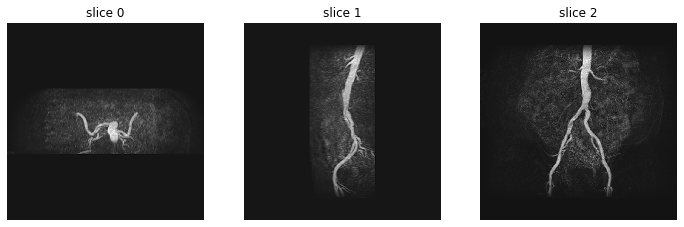

In [3]:
# Representació de les 3 imatges DICOM de la carpeta
def sample_stack(stack,rows=1,cols=3,show_every=1):
    fig,ax = plt.subplots(1,3,figsize=[12,12])
    print(fig)
    for i in range(cols):
        ind = i*show_every
        ax[i].set_title('slice %d' % ind)
        ax[i].imshow(stack[ind],cmap='gray')
        ax[i].axis('off')
    plt.show()

sample_stack(l)

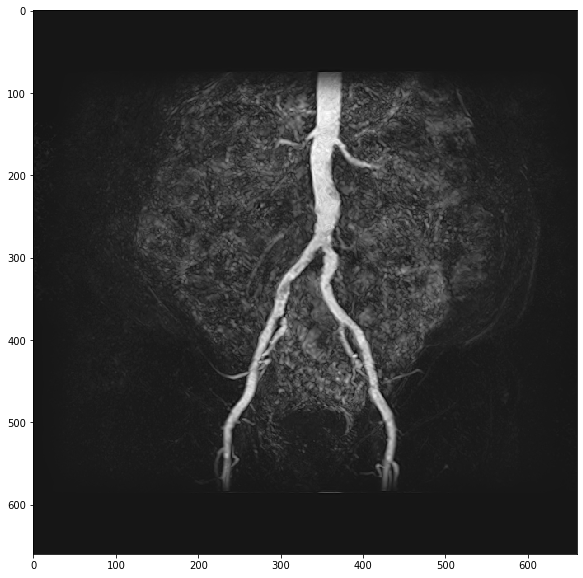

In [4]:
# Showing the image of interest
plt.figure(figsize=(10,10))
plt.imshow(l[2],cmap='Greys_r')
path='/Desktop/UNI/TFG/PythonCodes/PythonCodetest/Openingimage/First15Images/Imagestoworkwith'


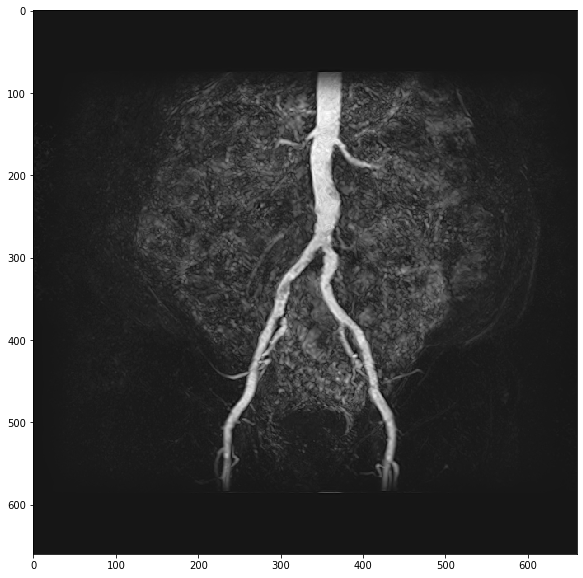

In [5]:
# Copy of the image
I_train=l[2]
plt.figure(figsize=(10,10))
plt.imshow(l[2],cmap='Greys_r')

In [6]:
# Convert it to float
I_train_float = img_as_float(I_train) 

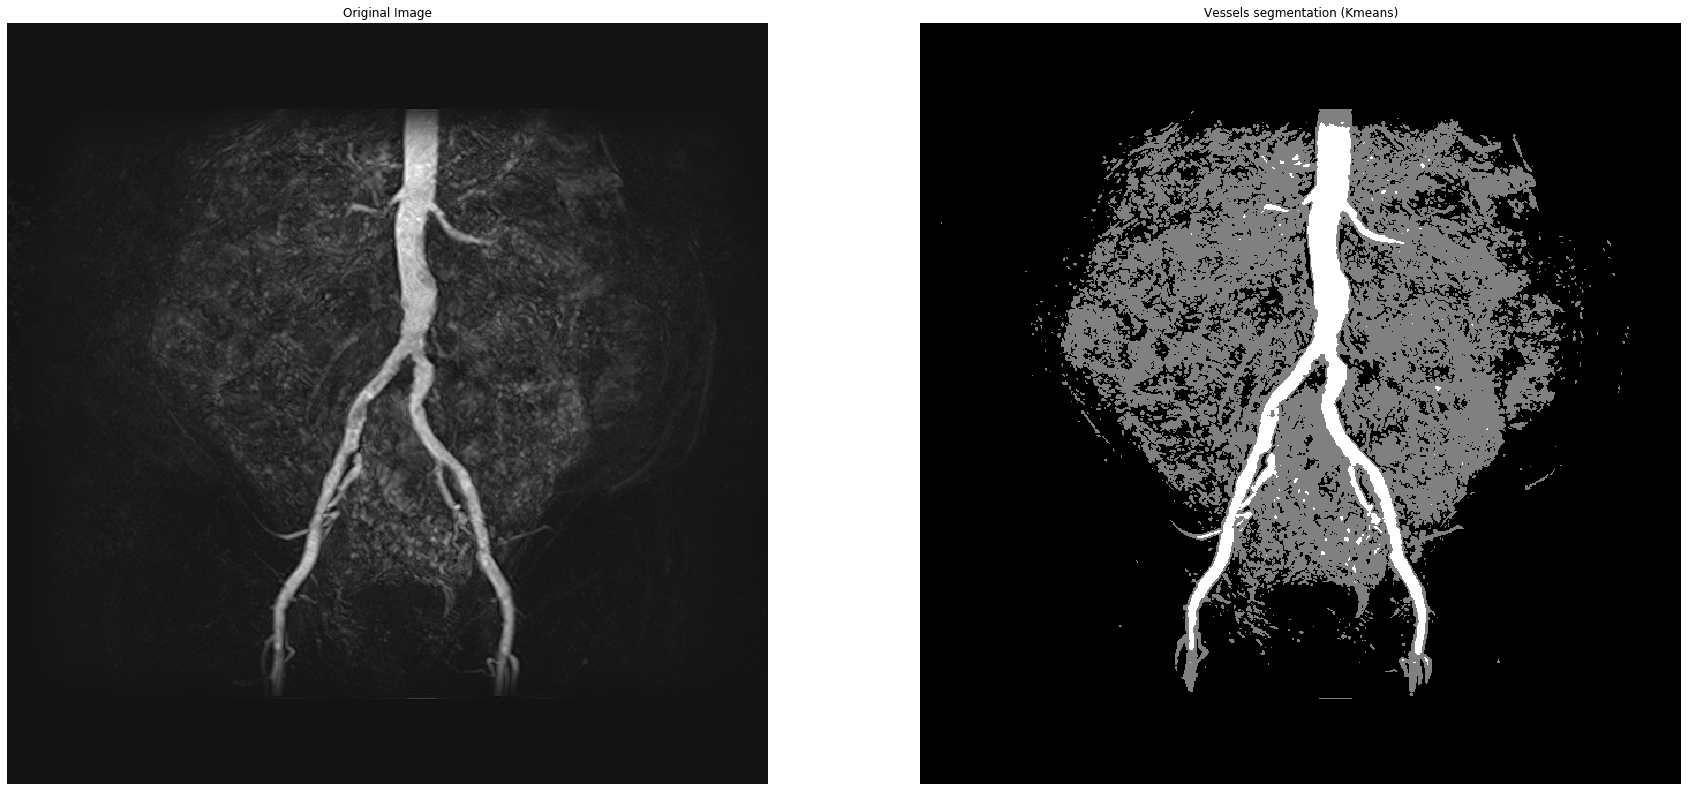

In [7]:
# reshape training image as 1d array:
v_I_train = I_train_float.reshape(I_train_float.shape[0]*I_train_float.shape[1],1).astype(np.float) 

# Fit a Kmeans clustering model with two clusters using training image:
kmeans= KMeans(n_clusters=3, random_state=0).fit(v_I_train)

v_kmeans = kmeans.predict(v_I_train)
I_kmeans = np.array(v_kmeans).reshape(l[2].shape[0],l[2].shape[1]).astype(np.uint8) # Shape back result as image 


fig = plt.figure(figsize=(30, 30))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_train_float, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Kmeans)')
ax2.set_axis_off()

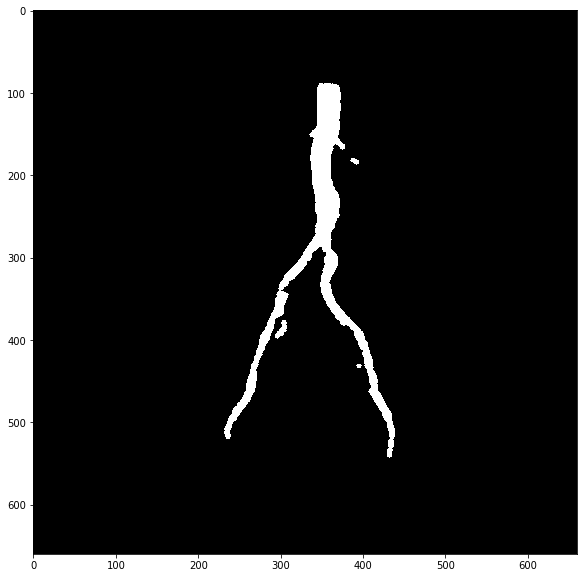

In [8]:
# We select the cluster corresponding to the aorta 
index=np.argmax(kmeans.cluster_centers_)
aorta=I_kmeans==index

# Morphological operation (EROSION) on binary image resulting from Otsu treshold
selem = disk(3)
eroded = erosion(aorta, selem)
dilated = dilation(eroded, selem)
plt.figure(figsize=(10,10))
plt.imshow(dilated,cmap='Greys_r')

In [9]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [10]:
# Labeling process
label_image, nregions = label(dilated,return_num=True)

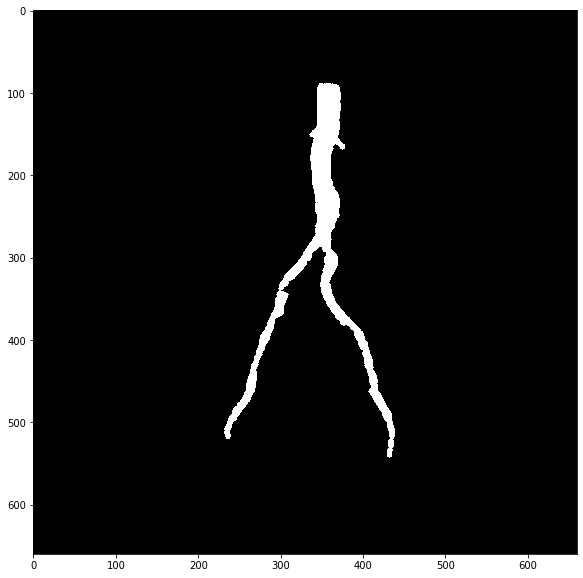

In [11]:
# Deleting non-interest regions
props=measure.regionprops(label_image)
va = []
for prop in props:
    va.append(prop.area)
indkeep = np.array(np.argmax(va))
v = np.arange(nregions)
vkill = np.setdiff1d(v,indkeep)+1 
I2 = dilated
for kkill in vkill:
    I2[label_image==kkill]=0
plt.figure(figsize=(10,10))
plt.imshow(I2,cmap='Greys_r')

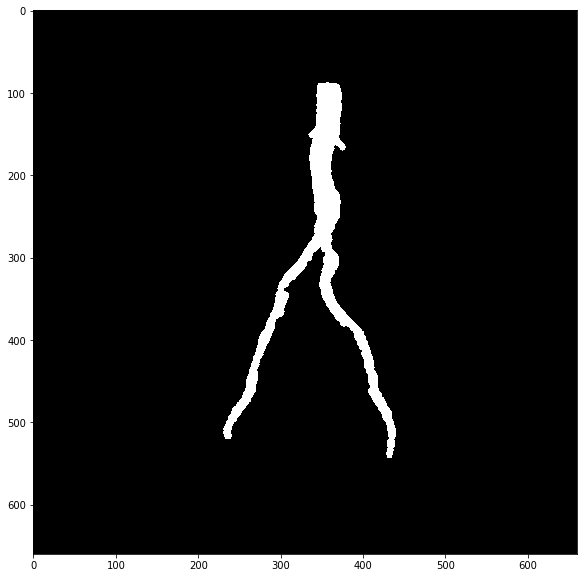

In [19]:
# Making the contour more regular
selem = disk(1)
dilated = dilation(I2, selem)
plt.figure(figsize=(10,10))
plt.imshow(dilated,cmap='Greys_r')

In [20]:
# Skeletonization
skeleton = skeletonize(dilated)

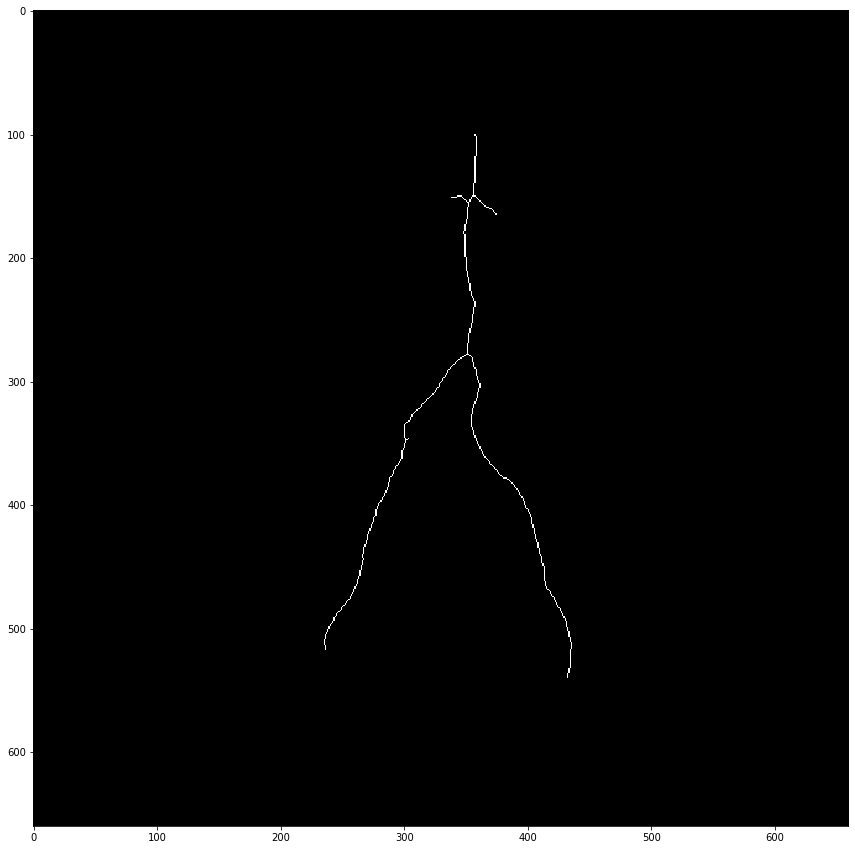

In [21]:
# Ploting the skeleton
plt.figure(figsize=(15,15))
plt.imshow(skeleton,cmap='Greys_r')

In [40]:
#### Function that finds the endpoints where the prunning will start
def endPoints(skel):
    endpoint1=np.array([[0, 0, 0], 
                         [0, 1, 0],
                         [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    endpoint9=np.array([[0, 0, 0],      
                        [0, 1, 1],      
                        [1, 0, 1]])
    
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep9=mh.morph.hitmiss(skel,endpoint9)
    ep = ep2+ep3+ep4+ep6+ep7+ep8+ep9
    return ep

In [41]:
# Main prunning function
def pruning(skeleton, size):
    '''remove iteratively end points "size" 
       times from the skeleton
    '''
    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

In [42]:
# Function that eliminates possible abnormalities in the upper part of the skeleton
def cleaningtop(branch):
    c=1
    for i in range(len(branch)):
            for j in range(len(branch)):
                if c<10:
                    if branch[i][j]==1:
                        branch[i][j]=0
                        c+=1
    return branch
            

In [43]:
# Same for the lower part
def cleaningbottom(branch):
    indexi=np.arange(branch.shape[0]-1,0,-1) #we will start checking the image from the botom of the image to get the first 12 cm
    indexj=np.arange(branch.shape[0]-1,0,-1)
    c=1
    for i in indexi:
        if c<20:
            for j in indexj:        
                if branch[i][j]==1:
                    branch[i][j]=0
                    c+=1
    return branch

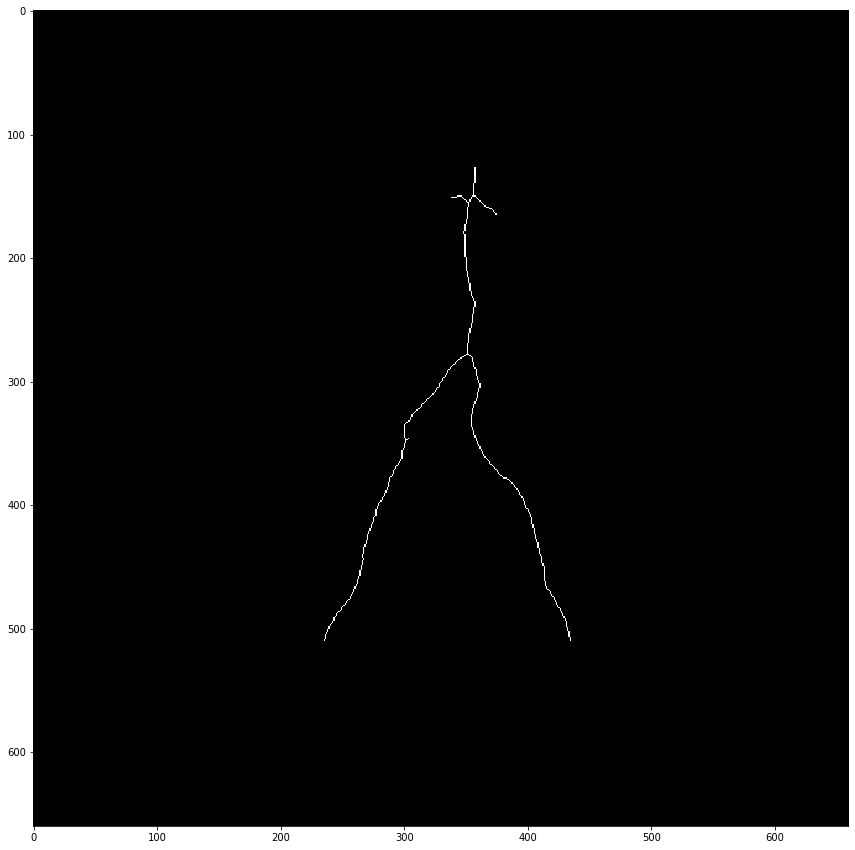

In [44]:
skeleton=cleaningtop(skeleton)
fig=plt.figure(figsize=(15,15))
plt.imshow(skeleton,cmap='Greys_r')

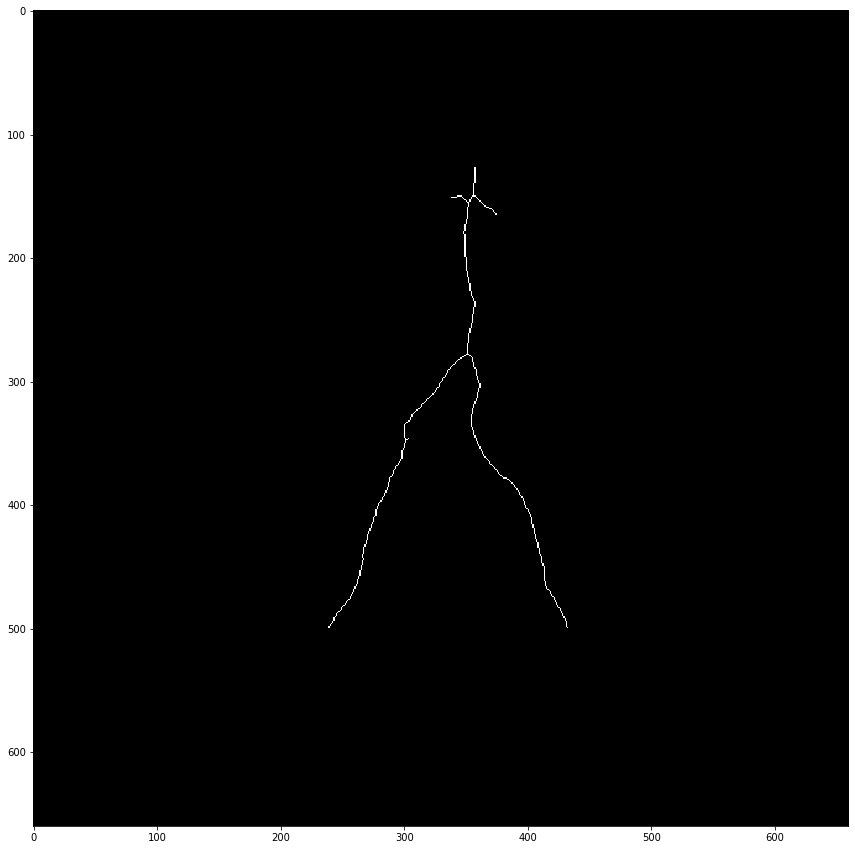

In [45]:
skeleton=cleaningbottom(skeleton)
fig=plt.figure(figsize=(15,15))
plt.imshow(skeleton,cmap='Greys_r')

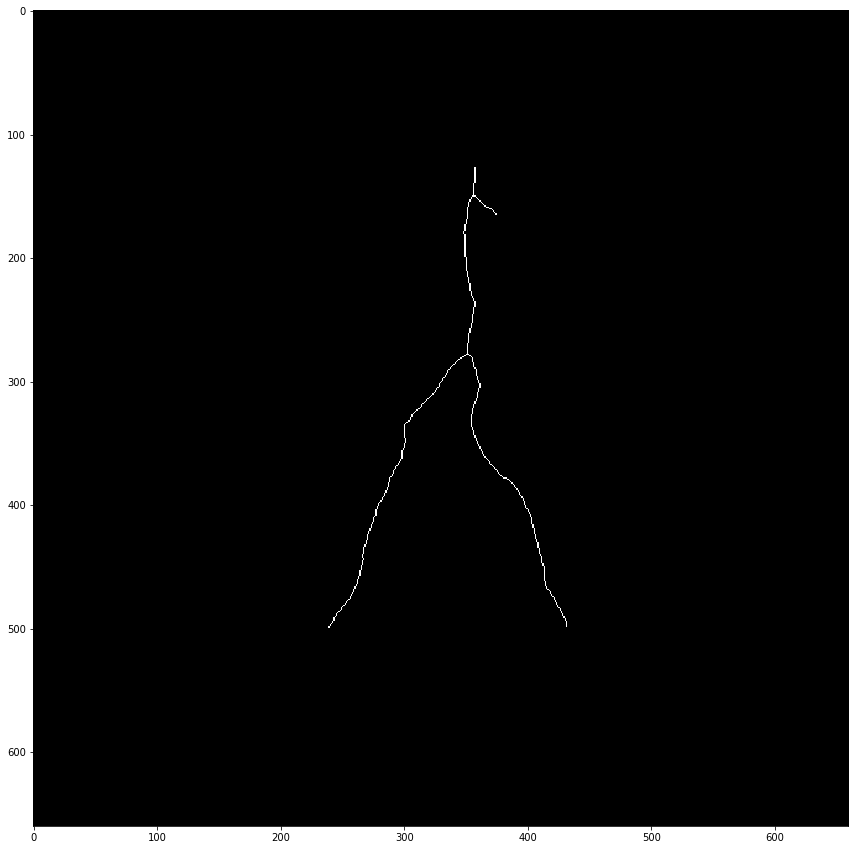

In [46]:
skeleton1 = pruning(skeleton,40)
fig=plt.figure(figsize=(15,15))
plt.imshow(skeleton1,cmap='Greys_r')

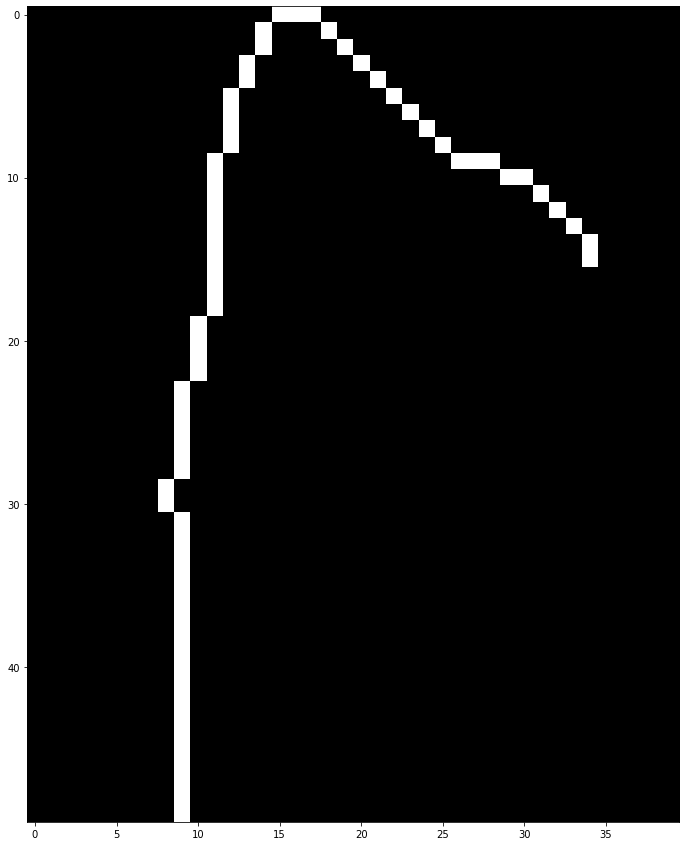

In [47]:
skeleton00=skeleton1[150:200,340:380]
fig=plt.figure(figsize=(15,15))
plt.imshow(skeleton00,cmap='Greys_r')

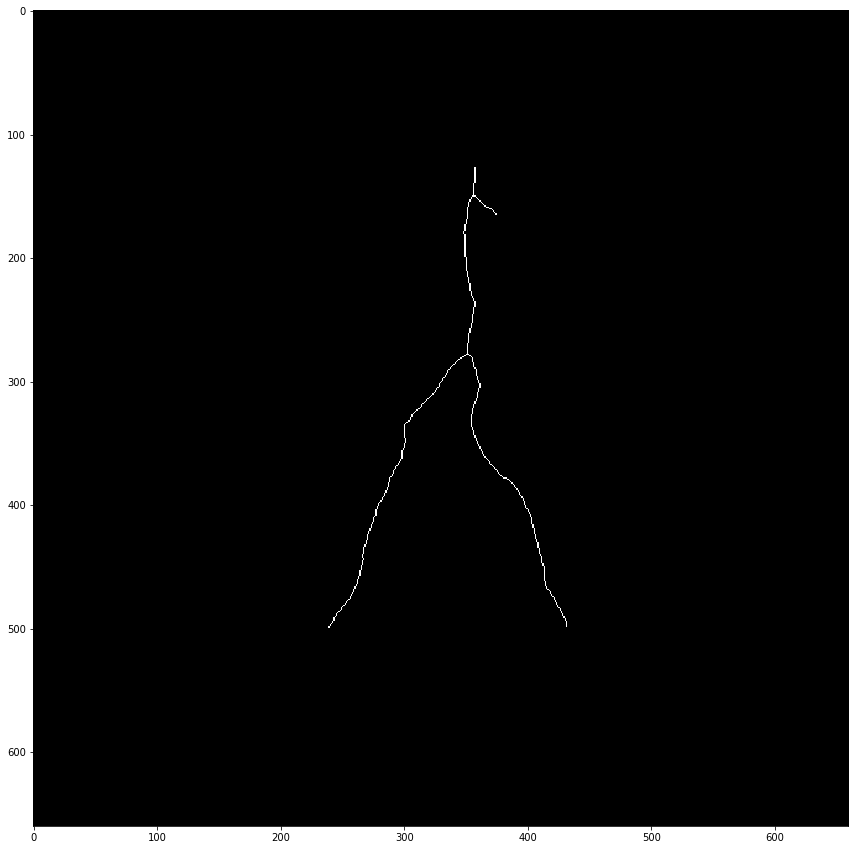

In [48]:
# Tornem a skeletonitzar però aquesta vegada ho fem de l'anterior skelet, obtingut després del prunning. En el procés de prunning
# s'havien generat zones on els píxels tenien més de 2 veïns, donant problemes en el posterior procés d'obtenció de les branques,
# ja que com separem branques en funció del nombre de veïns que tenen, obteniem més branques de les esperades!
skeleton2=skeletonize(skeleton1)
plt.figure(figsize=(15,15))
plt.imshow(skeleton2,cmap='Greys_r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


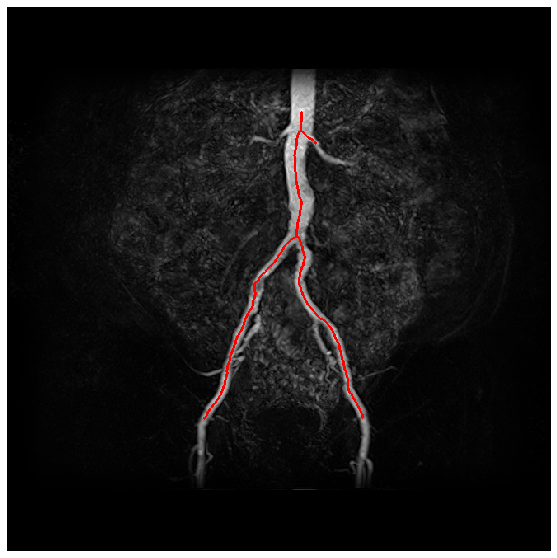

In [49]:
# overlay of the skeleton and the original image
from skan import draw
fig, ax = plt.subplots(figsize=(10,10))
draw.overlay_skeleton_2d(l[2], skeleton2, dilate=1, axes=ax)
plt.show()

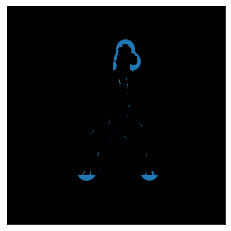

In [51]:
# We analise the skeleton to find the 3 branches
pixel_graph, coordinates, degrees = skeleton_to_csgraph(skeleton2,spacing=pixspac)
branch_data = summarize(Skeleton(skeleton2, spacing=pixspac))
draw.overlay_skeleton_networkx(pixel_graph, coordinates, image=skeleton2)

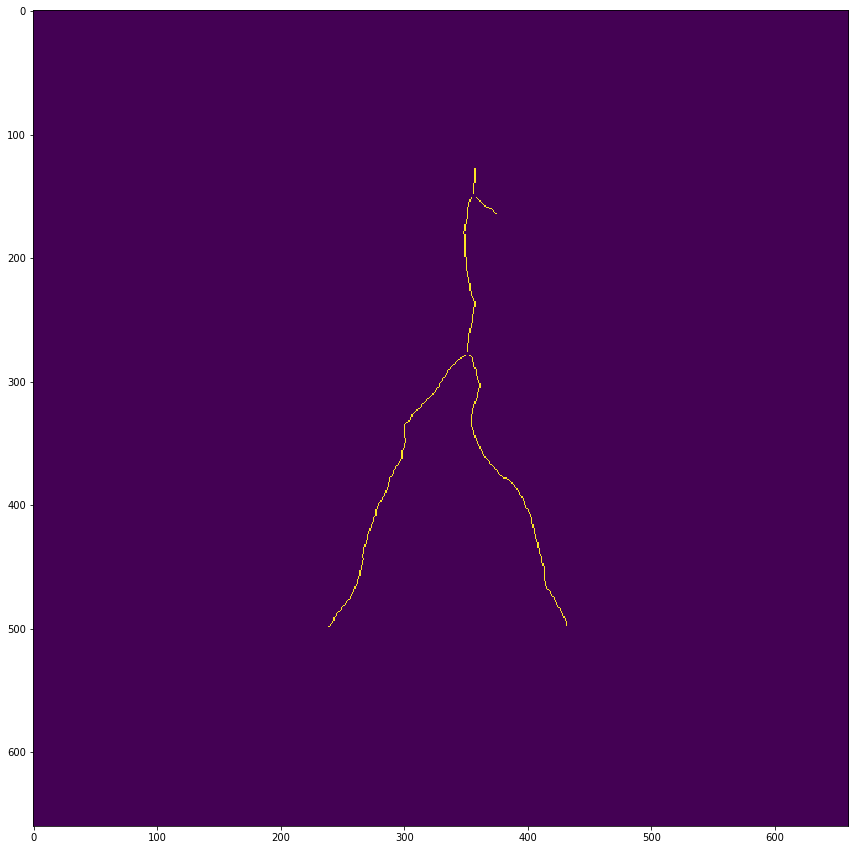

In [88]:
# To separate the branches
i=degrees==2
fig=plt.figure(figsize=(15,15))
plt.imshow(i)


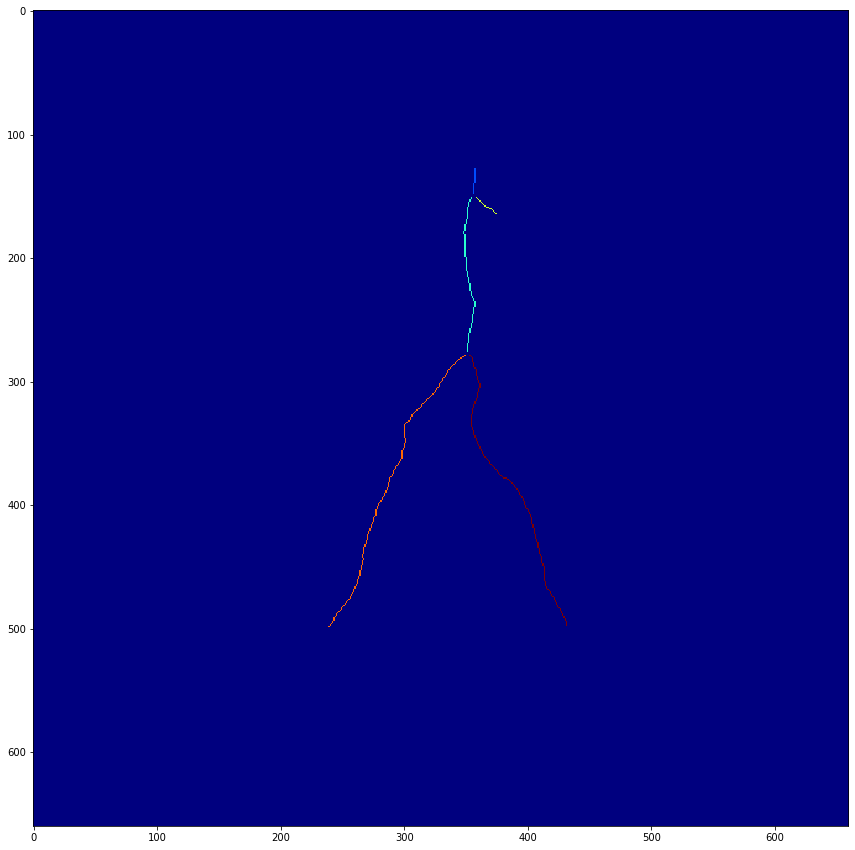

In [89]:
# Labelling of each branch
labeled_branch, nbranches = label(i,return_num=True)
fig=plt.figure(figsize=(15,15))
plt.imshow(labeled_branch,cmap='jet')

In [55]:
# Function to count how many pixels belong to a branch
def howmanypixels(branch):
    l=0
    for i in range(len(branch)):
        for j in range(len(branch)):
            if branch[i][j]==1:
                l+=1
    return l

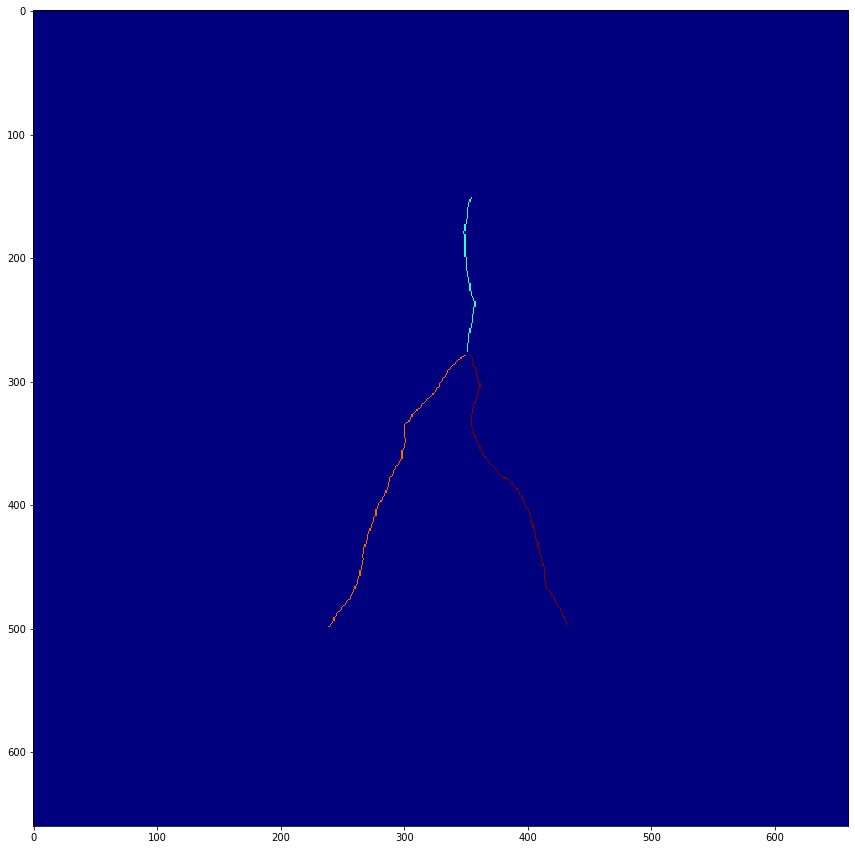

In [92]:
# We remove the small branches in orde to remove the attached branches to our main structure
labeled_branch2=labeled_branch
for i in range(1,nbranches+1):
    if howmanypixels(labeled_branch2==i)<30:
        labeled_branch2[labeled_branch2==i]=0

fig=plt.figure(figsize=(15,15))
plt.imshow(labeled_branch2,cmap='jet')
    

In [118]:
# Function to join again the branches
# we will set to True if a pixel False is between two True pixels
def connecting(image):
    for i in range(1,len(image)-1):
        for j in range(1,len(image)-1):
            if image[i-1,j-1]==True or image[i-1,j]==True or image[i-1,j+1]==True and image[i,j]==False and image[i+1,j-1]==True or image[i+1,j]==True or image[i+1,j+1]==True:
                image[i,j]=True
    return image

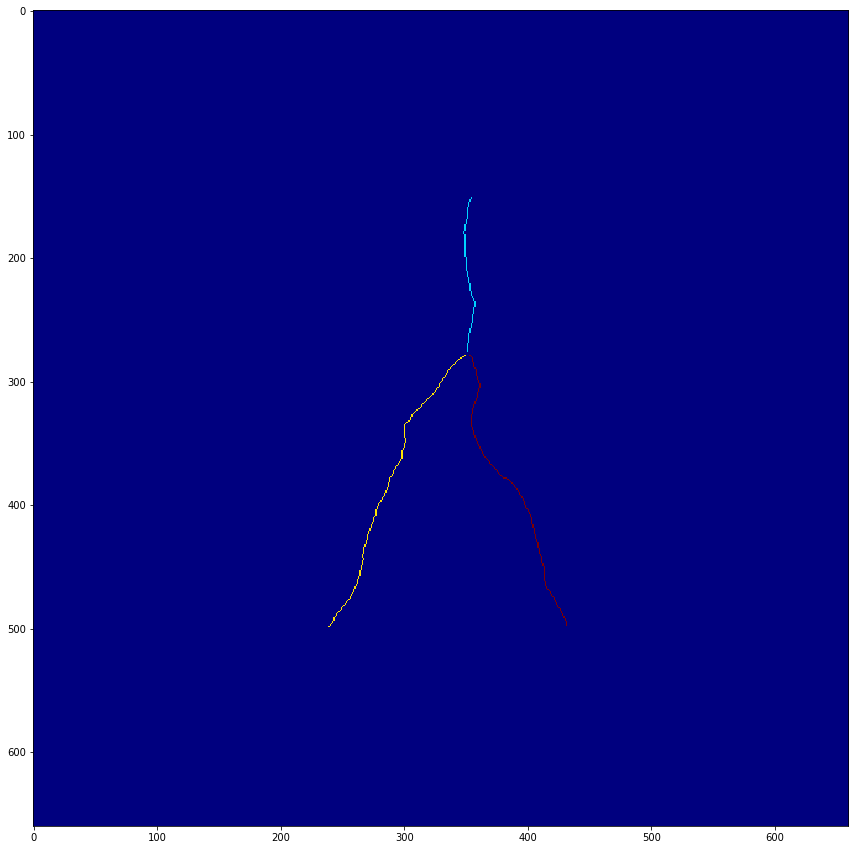

In [120]:
labeled_branch3=connecting(labeled_branch2)
labeled_branch4, nbranches4 = label(labeled_branch3,return_num=True)
fig=plt.figure(figsize=(15,15))
plt.imshow(labeled_branch4,cmap='jet')

In [123]:
# We extract again these properties
pixel_graph2, coordinates2, degrees2 = skeleton_to_csgraph(labeled_branch4,spacing=pixspac)
branch_data2 = summarize(Skeleton(labeled_branch4, spacing=pixspac))
branch_data2

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,1,1,126,91.396284,0,1.0,0.0,151.0,354.0,276.0,351.0,103.2236,241.9944,188.6736,239.9436,85.474606
1,2,127,572,183.590003,0,1.0,0.0,279.0,349.0,498.0,239.0,190.7244,238.5764,340.4328,163.3804,167.532216
2,3,128,571,176.276519,0,1.0,0.0,279.0,353.0,497.0,431.0,190.7244,241.3108,339.7492,294.6316,158.276653


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 659.5, 659.5, -0.5)

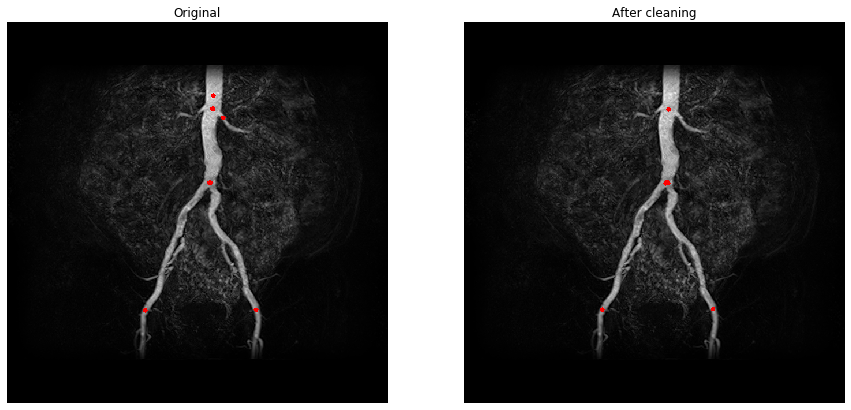

In [129]:
# Identification of the original endpoints and junctionpoitns
endpoints=degrees==1
junctionpoint=degrees==3
points=endpoints+junctionpoint
new_endpoints=degrees2==1

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15), sharex=True,sharey=True)
draw.overlay_skeleton_2d(l[2], points, dilate=4, axes=ax1)
ax1.set_title('Original')
ax1.axis('off')
draw.overlay_skeleton_2d(l[2],new_endpoints, dilate=4, axes=ax2)
ax2.set_title('After cleaning')
ax2.axis('off')

In [135]:
# We locate the main bifurcation point
position=[]
for i,e in enumerate(junctionpoint):
    if 260<i<320 and 32t:
        for t,r in enumerate(junctionpoint):
            if junctionpoint[i][t]==True:
                position.append([i,t])
if len(position)==3:
    position=position[1]
else:
    position=position[0]                
position
        

[278, 351]

In [136]:
# Create a table with the computed Tortuosity measure 
def table (branch):
    pixel_graph, coordinates, degrees = skeleton_to_csgraph(branch,unique_junctions=False)
    branch_data = summarize(Skeleton(branch, spacing=pixspac))    
    branch_data['Tortuosity_1'] = branch_data.apply(lambda row: row['branch-distance']/row['euclidean-distance'], axis=1)
    branch_data['Tortuosity_2'] = branch_data.apply(lambda row: row['branch-distance'] - row['euclidean-distance'], axis=1)
    return branch_data

# Get the coordinates of the pixels belonging to each branch
def getcoordinates(branch):
    pixel_graph, coordinates, degrees = skeleton_to_csgraph(branch,unique_junctions=False)
    return coordinates

In [137]:
# For the infrarenal Aorta artery
# Deciding which pixels are vertically aligned and which pixels are diagonally aligned 

dstdiagonal=np.sqrt((pixspac**2)+(pixspac**2)) # # diagonal distance in mm between the pixels of the image where pixspac is the space between the centers of neighboring pixels 
def type_of_neighborsaorta(branch,c):
    branchcoordinates=getcoordinates(branch)
    vertical=[]
    diagonal=[]
    l=c
    index=np.arange(len(branchcoordinates)-1,1,-1) # We turn around the coordinates vector to star the process at the bottom.
    for i in index:
        dx1=(branchcoordinates[i-1][0]-branchcoordinates[i][0])**2
        dx2=(branchcoordinates[i-1][1]-branchcoordinates[i][1])**2
        dst=np.sqrt(dx1+dx2)
        round(dst,4)
        
        if dst==np.sqrt(2): #if it is square root of 2 it means boths pixels are into a diagonal line
            if l>0:
                l-=dstdiagonal
                diagonal.append([branchcoordinates[i-1][0],branchcoordinates[i-1][1]])
                diagonal.append([branchcoordinates[i][0],branchcoordinates[i][1]])
            
        elif dst==1: #if it is 1 it means 1 pixel is above the other
            if l>0:
                l-=pixspac
                vertical.append([branchcoordinates[i-1][0],branchcoordinates[i-1][1]])
                vertical.append([branchcoordinates[i][0],branchcoordinates[i][1]])
    return vertical,diagonal,l

In [138]:
# For the Iliac arteries
# Deciding which pixels are vertically aligned and which pixels are diagonally aligned  

def type_of_neighborsiliac(branch,c):
    branchcoordinates=getcoordinates(branch)
    vertical=[]
    diagonal=[]
    l=c
    
    for i in range(1,len(branchcoordinates)):
        dx1=(branchcoordinates[i-1][0]-branchcoordinates[i][0])**2
        dx2=(branchcoordinates[i-1][1]-branchcoordinates[i][1])**2
        dst=np.sqrt(dx1+dx2)
        round(dst,4)
        
        if dst==np.sqrt(2): #if it is square root of 2 it means boths pixels are into a diagonal line
            if l>0:
                l-=dstdiagonal
                diagonal.append([branchcoordinates[i-1][0],branchcoordinates[i-1][1]])
                diagonal.append([branchcoordinates[i][0],branchcoordinates[i][1]])
            
        elif dst==1: #if it is 1 it means 1 pixel is above the other
            if l>0:
                l-=pixspac
                vertical.append([branchcoordinates[i-1][0],branchcoordinates[i-1][1]])
                vertical.append([branchcoordinates[i][0],branchcoordinates[i][1]])
        elif 2<dst<3:
            if l>0:
                l-=dstdiagonal
                diagonal.append([branchcoordinates[i-1][0],branchcoordinates[i-1][1]])
                diagonal.append([branchcoordinates[i][0],branchcoordinates[i][1]])
    return vertical,diagonal,l

In [139]:
# we create a function that classifies the pixels of the segment under study in 2 lists, according to whether they are 
# diagonally or vertically to their previous neighbour. We can also set the exact desired distance of the branch 

# For the Aorta
def setlength_aorta2(branch):
    indexi=np.arange(branch.shape[0]-1,0,-1) #we will start checking the image from the botom of the image to get the first 11 cm
    indexj=np.arange(branch.shape[0]-1,0,-1)
    vertical=type_of_neighborsaorta(branch,100)[0]
    diagonal=type_of_neighborsaorta(branch,100)[1]
    for i in indexi:
        for j in indexj:
                if [i,j] in vertical:
                    if i<position[0]:
                        branch[i][j]=1
                elif [i,j] in diagonal:
                    if i<position[0]:
                        branch[i][j]=1
                else:
                    branch[i][j]=0
    return branch
                        
                        
                    

In [140]:
# For the Iliac
def setlength_iliac2(branch):
    vertical=type_of_neighborsiliac(branch,50)[0]
    diagonal=type_of_neighborsiliac(branch,50)[1]
    for i in range(len(branch)):
        for j in range(len(branch)):
            if [i,j] in vertical:
                    branch[i][j]=1
            elif [i,j] in diagonal:
                    branch[i][j]=1
            else:
                branch[i][j]=0
    return branch
                        
                        
                    
                

In [141]:
# Function to plot the segment analyzed and show the measure
def represent(branch):
    fig, ax = plt.subplots(figsize=(10,10))
    draw.overlay_skeleton_2d(l[2], branch, dilate=1, axes=ax)
    plt.title('Tortuosity:{}, Length:{} mm'.format(round(table(branch)['Tortuosity_2'][0],4),round(table(branch)['branch-distance'][0],2)), fontsize=20)
    plt.show()

In [142]:
# We assign a label to each branch
aorta=labeled_branch4==1
iliac1=labeled_branch4==2
iliac2=labeled_branch4==3


In [143]:
aortamod=setlength_aorta2(aorta)
table(aortamod)

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance,Tortuosity_1,Tortuosity_2
0,1,1,126,91.396284,0,1.0,0.0,151.0,354.0,276.0,351.0,103.2236,241.9944,188.6736,239.9436,85.474606,1.06928,5.921678


In [144]:
iliac11=setlength_iliac2(iliac1)
table(iliac11)

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance,Tortuosity_1,Tortuosity_2
0,1,1,59,51.824525,0,1.0,0.0,279.0,349.0,333.0,302.0,190.7244,238.5764,227.6388,206.4472,48.938312,1.058977,2.886212


In [145]:
iliac22=setlength_iliac2(iliac2)
table(iliac22)

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance,Tortuosity_1,Tortuosity_2
0,1,1,67,50.214415,0,1.0,0.0,279.0,353.0,345.0,357.0,190.7244,241.3108,235.842,244.0452,45.200385,1.110929,5.01403


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


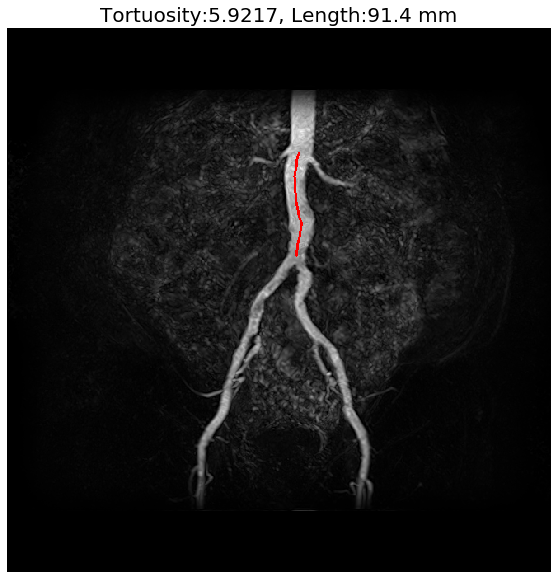

In [146]:
represent(aortamod)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


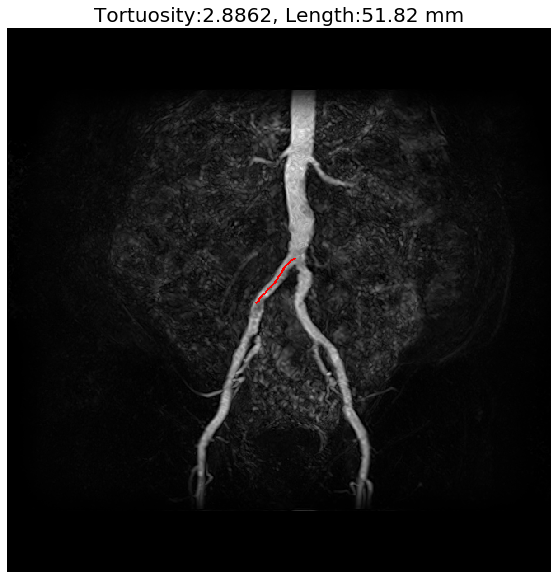

In [147]:
represent(iliac11)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


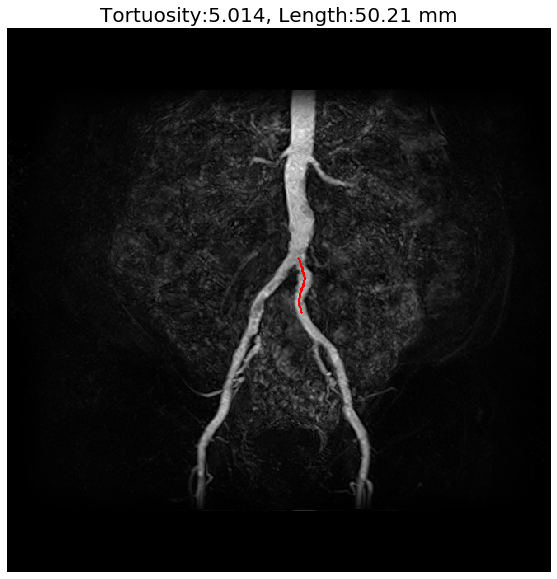

In [148]:
represent(iliac22)

# Preparing the final Pandas dataframe of the patient 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


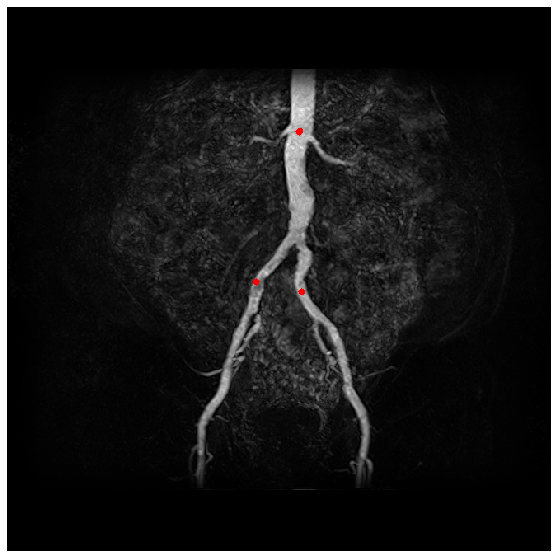

Text(0.5, 1.0, 'End points and junction points of the aorta and the iliac arteries')

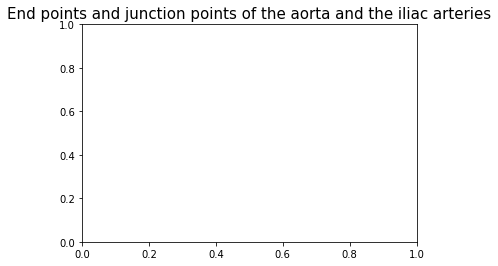

In [149]:
# Now that we have the branches with the desired length, we find the new endpoints and its coordinates
# Finally we plot it

_,_,degrees1 = skeleton_to_csgraph(aortamod,spacing=pixspac)
endpoints1=degrees1==1

_,_,degrees2 = skeleton_to_csgraph(iliac11,spacing=pixspac)
endpoints2=degrees2==1

_,_,degrees3 = skeleton_to_csgraph(iliac22,spacing=pixspac)
endpoints3=degrees3==1

analysys_points=endpoints1+endpoints2+endpoints3

def getstartingpoint(branch):
    l=0
    p=[]
    for i in range(len(branch)):
        for j in range(len(branch)):
            if l==0:
                if branch[i][j]==1:
                    l+=1
                    p.append(i)
                    p.append(j)
            else:  
                branch[i][j]=0    
    return branch,p

def getfinalpoint(branch):
    indexi=np.arange(branch.shape[0]-1,0,-1) #we will start checking the image from the botom of the image to get the first 11 cm
    indexj=np.arange(branch.shape[0]-1,0,-1)
    l=0
    p=[]
    for i in indexi:
        for j in indexj:
            if l==0:
                if branch[i][j]==1:
                    l+=1
                    p.append(i)
                    p.append(j)
            else:  
                branch[i][j]=0    
    return branch,p

p1x=getstartingpoint(endpoints1)[1][0]
p1y=getstartingpoint(endpoints1)[1][1]
p2x=getfinalpoint(endpoints2)[1][0]
p2y=getfinalpoint(endpoints2)[1][1]
p3x=getfinalpoint(endpoints3)[1][0]
p3y=getfinalpoint(endpoints3)[1][1]
p4x=getstartingpoint(junctionpoint)[1][0]
p4y=getstartingpoint(junctionpoint)[1][1]

imagepoint1=getstartingpoint(endpoints1)[0]
imagepoint2=getfinalpoint(endpoints2)[0]
imagepoint3=getfinalpoint(endpoints3)[0]
imagepoint4=junctionpoint

analysys_points=imagepoint1+imagepoint2+imagepoint3+imagepoint4

fig, ax = plt.subplots(figsize=(10,10))
draw.overlay_skeleton_2d(l[2], analysys_points, dilate=4, axes=ax)
plt.show()
plt.title('End points and junction points of the aorta and the iliac arteries', size=15)

In [150]:
# We assign the values 

s1l=round(table(aortamod)['branch-distance'][0],2)
s1_t1=round(table(aortamod)['Tortuosity_1'][0],2)
s1_t2=round(table(aortamod)['Tortuosity_2'][0],2)
s2l=round(table(iliac11)['branch-distance'][0],2)
s2_t1=round(table(iliac11)['Tortuosity_1'][0],2)
s2_t2=round(table(iliac11)['Tortuosity_2'][0],2)
s3l=round(table(iliac22)['branch-distance'][0],2)
s3_t1=round(table(iliac22)['Tortuosity_1'][0],2)
s3_t2=round(table(iliac22)['Tortuosity_2'][0],2)


In [151]:
# We create the Pandas DataFrame
data={'Patient ID':[ds.PatientID],'p1x':[p1x],'p1y':[p1y],'p2x':[p2x],'p2y':[p2y],'p3x':[p3x],'p3y':[p3y],'p4x':[p4x],'p4y':[p4y],'Aorta-l':[s1l],'Aorta_t1':[s1_t1],'Aorta_t2':[s1_t2],'R-Iliac-l':[s2l],'R-Iliac_t1':[s2_t1],'R-Iliac_t2':[s2_t2],'L-Iliac-l':[s3l],'L-Iliac_t1':[s3_t1],'L_Iliac_t2':[s3_t2],}
df = pd.DataFrame(data)
df.index+=1



In [152]:
# Styling the dataframe
def tortuosity_red(x):
    r = 'background-color: yellow'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, 11] = r
    df1.iloc[:, 14] = r
    df1.iloc[:, 17] = r
    return df1    
df.style.apply(tortuosity_red, axis=None)

,Patient ID,p1x,p1y,p2x,p2y,p3x,p3y,p4x,p4y,Aorta-l,Aorta_t1,Aorta_t2,R-Iliac-l,R-Iliac_t1,R-Iliac_t2,L-Iliac-l,L-Iliac_t1,L_Iliac_t2
1,49-0,151,354,333,302,345,357,150,355,91.4,1.07,5.92,51.82,1.06,2.89,50.21,1.11,5.01


In [153]:
# we create the CSV and save it in a folder with the rest of CSV files to later on generate the final Excel
identifier=ds.PatientID
csv_path=r"C:\Users\danib\Desktop\UNI\TFG\Python Codes\Python Code test\Opening image\First 15 Images\bifurcacion\bifurcacion\3_Reconstruction\CSV"+'/'+identifier +".csv"
xlsx_path=r"C:\Users\danib\Desktop\UNI\TFG\Python Codes\Python Code test\Opening image\First 15 Images\bifurcacion\bifurcacion\3_Reconstruction\CSV\18-1.xlsx"
df.to_csv(csv_path,sep=str(','),index=False,header=True,encoding='utf-8') # We don't export the header, we only want the values

""""
writer = pd.ExcelWriter(xlsx_path, mode='a',engine='openpyxl') 
df.to_excel(writer)
writer.save()
writer.close()
"""

'"\nwriter = pd.ExcelWriter(xlsx_path, mode=\'a\',engine=\'openpyxl\') \ndf.to_excel(writer)\nwriter.save()\nwriter.close()\n'